In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import keras

import fidle.pwk as pwk

image200.jpg


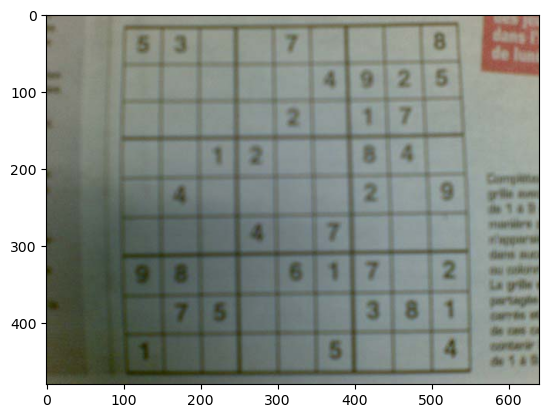

In [46]:
folder=r"v1_training/v1_training/Image"
import os
import random

Grille=random.choice(os.listdir(folder))
print(Grille)
sudoku_Grille = cv2.imread(folder + '/' + Grille)

if sudoku_Grille is not None:
	plt.figure()
	plt.imshow(cv2.cvtColor(sudoku_Grille, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
	plt.show()
else:
	print(f"Error: Unable to load image {folder + '/' + Grille}")

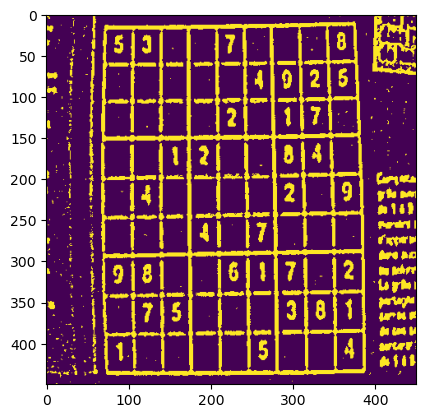

In [47]:
#Preprocessing image to be read
sudoku_Grille = cv2.resize(sudoku_Grille, (450,450))

# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    #blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = preprocess(sudoku_Grille)

#let's look at what we have got
plt.figure()
plt.imshow(threshold)
plt.show()

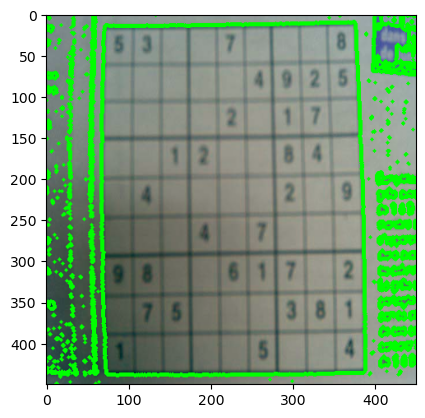

In [48]:
# Finding the outline of the sudoku puzzle in the image
contour_1 = sudoku_Grille.copy()
contour_2 = sudoku_Grille.copy()
contour, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour,-1,(0,255,0),3)

#let's see what we got
plt.figure()
plt.imshow(contour_1)
plt.show()

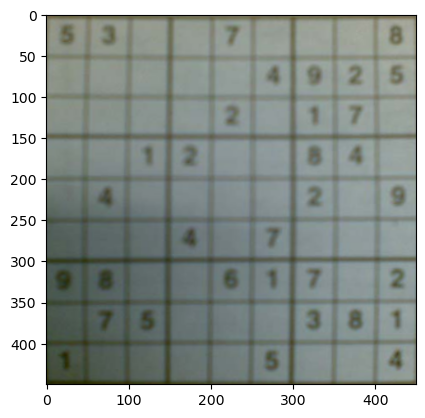

In [49]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes


black_img = np.zeros((450,450,3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)  
    imagewrap = cv2.warpPerspective(sudoku_Grille,matrix,(450,450))
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGRA2RGB)
    
plt.figure()
plt.imshow(imagewrap)
plt.show()